##Setting Up Environment

In [26]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-01-03 05:49:47--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2025-01-03 05:49:47 (86.3 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


##PreProcessing Steps

In [3]:
df = dataset.copy()
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
expenses,0


In [4]:
df.duplicated().sum()

1

In [5]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,expenses
581,19,male,30.6,0,no,northwest,1639.56


In [6]:
df[df['expenses']==1639.56]

,age,sex,bmi,children,smoker,region,expenses
195,19,male,30.6,0,no,northwest,1639.56
581,19,male,30.6,0,no,northwest,1639.56


In [7]:
df = df.drop_duplicates()

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.00,27.00,39.00,51.00,64.00
bmi,1337.0,30.665520,6.100664,16.00,26.30,30.40,34.70,53.10
children,1337.0,1.095737,1.205571,0.00,0.00,1.00,2.00,5.00
expenses,1337.0,13279.121638,12110.359657,1121.87,4746.34,9386.16,16657.72,63770.43


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   expenses  1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [10]:
df.nunique()

,0
age,47
sex,2
bmi,275
children,6
smoker,2
region,4
expenses,1337


##LabelEncoding Model Creation

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('expenses', axis=1), df['expenses'], test_size=0.2, random_state=42)

In [13]:
x_train.head()

,age,sex,bmi,children,smoker,region
1114,23,1,24.5,0,0,0
968,21,1,25.7,2,0,0
599,52,0,37.5,2,0,1
170,63,1,41.5,0,0,2
275,47,0,26.6,2,0,0


In [16]:
result = {}
result

{}

In [48]:
def get_checkpoints():
  return [keras.callbacks.ModelCheckpoint(filepath = "linear_model.keras",
                                          monitor = 'val_root_mean_squared_error',
                                          mode = 'min',
                                          verbose = 1,
                                          save_best_only = True),
          tfdocs.modeling.EpochDots(),
          keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 200, mode ='min')
          ]

def compile_and_fit(model, x_train, y_train):
  model.summary()
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mse',metrics= [keras.metrics.RootMeanSquaredError()])
  history = model.fit(x_train,
                      y_train,
                      epochs=50,
                      validation_split=0.2,
                      callbacks = get_checkpoints(),
                      verbose = 0
                      )
  return history

normalizer_model = keras.Sequential([
  layers.Dense(64,activation='elu',kernel_regularizer = regularizers.l2(0.001),input_shape = (6,)),
  layers.Dense(64,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
  layers.Dense(1)
])

result['normalized_model'] = compile_and_fit(normalizer_model, x_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: val_root_mean_squared_error improved from inf to 11441.82617, saving model to linear_model.keras

Epoch: 0, loss:177705728.0000,  root_mean_squared_error:13330.6309,  val_loss:130915384.0000,  val_root_mean_squared_error:11441.8262,  
.
Epoch 2: val_root_mean_squared_error improved from 11441.82617 to 11017.07520, saving model to linear_model.keras
.
Epoch 3: val_root_mean_squared_error improved from 11017.07520 to 10224.02539, saving model to linear_model.keras
.
Epoch 4: val_root_mean_squared_error improved from 10224.02539 to 9063.56738, saving model to linear_model.keras
.
Epoch 5: val_root_mean_squared_error improved from 9063.56738 to 6452.17383, saving model to linear_model.keras
.
Epoch 6: val_root_mean_squared_error did not improve from 6452.17383
.
Epoch 7: val_root_mean_squared_error did not improve from 6452.17383
.
Epoch 8: val_root_mean_squared_error improved from 6452.17383 to 6202.00977, saving model to linear_model.keras
.
Epoch 9: val_root_mean_squared_error

Text(0, 0.5, 'RMSE')

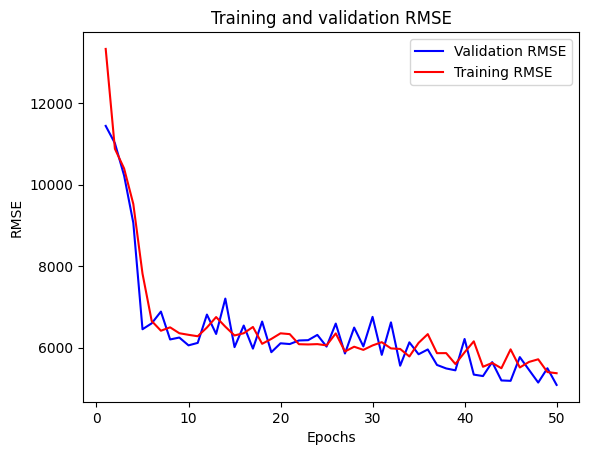

In [49]:
#with regularization

train_accuracy = result['normalized_model'].history['root_mean_squared_error']
val_accuracy = result['normalized_model'].history['val_root_mean_squared_error']
epochs = range(1, len(val_accuracy) + 1)
plt.plot(epochs, val_accuracy, 'b', label='Validation RMSE')
plt.plot(epochs, train_accuracy, 'r', label='Training RMSE')
plt.title('Training and validation RMSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')

In [50]:
from keras.models import load_model

model = load_model('linear_model.keras')

In [25]:
#without regularization
print("Saved Training RMSE Mean: ", np.mean(train_accuracy))
print("Saved Validation RMSE Mean: ", np.mean(val_accuracy))

Saved Training RMSE Mean:  7724.307744140625
Saved Validation RMSE Mean:  7723.132412109375


In [52]:
#with regularization
print("Saved Training RMSE Mean: ", np.mean(train_accuracy))
print("Saved Validation RMSE Mean: ", np.mean(val_accuracy))

Saved Training RMSE Mean:  6499.006904296875
Saved Validation RMSE Mean:  6372.759111328125


In [22]:
#without regularization
from sklearn.metrics import root_mean_squared_error, mean_squared_error

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
print('Train RMSE: ', root_mean_squared_error(y_train, train_pred))
print('Test RMSE: ', root_mean_squared_error(y_test, test_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE:  6067.254306680766
Test RMSE:  6060.148696130298


In [53]:
#with regularization
from sklearn.metrics import root_mean_squared_error, mean_squared_error

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
print('Train RMSE: ', root_mean_squared_error(y_train, train_pred))
print('Test RMSE: ', root_mean_squared_error(y_test, test_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE:  5215.780840559106
Test RMSE:  4979.7296621017995


In [23]:
#without regularization
print('Train RMSE: ', mean_squared_error(y_train, train_pred))
print('Test RMSE: ', mean_squared_error(y_test, test_pred))

Train RMSE:  36811574.821936294
Test RMSE:  36725402.21920975


In [54]:
#with regularization
print('Train RMSE: ', mean_squared_error(y_train, train_pred))
print('Test RMSE: ', mean_squared_error(y_test, test_pred))

Train RMSE:  27204369.776743453
Test RMSE:  24797707.507616498
